In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
def get_xt(df):
    columns = ['hr_state', 'sysbp_state', 'percoxyg_state', 'antibiotic_state', 'vaso_state', 'vent_state']
    categ_num = np.array([3, 3, 2, 2, 2, 2])
    sum_idx = 0
    prev_base = 1
    for i in range(len(columns)):
        idx = len(columns) - 1 - i
        sum_idx += prev_base * df[columns[idx]]
        prev_base *= categ_num[idx]
    df['X_t'] = sum_idx
    return df

In [3]:
observational_data = pd.read_csv("/data/localhost/taufiq/sontag-simulator-data/data.csv")
observational_data = get_xt(observational_data)

In [4]:
observational_data.head()

,hr_state,sysbp_state,percoxyg_state,glucose_state,antibiotic_state,vaso_state,vent_state,diabetic_idx,id,A_t,t,X_t
0,2,1,1,3,0,0,0,1,0,6,0,120
1,1,1,1,4,1,0,1,1,0,-1,1,77
2,1,1,1,1,0,0,0,0,1,4,0,72
3,1,1,1,2,1,0,0,0,1,-1,1,76
4,0,0,1,2,0,0,0,0,2,3,0,8


In [5]:
simulator_data = pd.read_csv("/data/localhost/taufiq/sontag-simulator-data/data_antibiotic2.csv").astype(int)

In [6]:
simulator_data.head()

,hr_state,sysbp_state,percoxyg_state,glucose_state,antibiotic_state,vaso_state,vent_state,diabetic_idx,id,t
0,0,0,1,1,0,0,0,1,0,0
1,0,0,1,1,1,0,1,1,0,1
2,2,0,1,1,0,0,0,1,1,0
3,1,0,1,2,1,1,1,1,1,1
4,1,2,1,1,0,0,0,1,2,0


In [7]:
def get_a0(df):
    actions = df[df['t']==1]
    actions.index = actions['id']
    actions = 4*actions['antibiotic_state'] + 2*actions['vent_state'] + actions['vaso_state']
    for index, row in df.iterrows():
        if row['t'] == 1:
            df.at[index, 'A_t'] = -1
        else:
            df.at[index, 'A_t'] = actions[row['id']]
    return df.astype(int)

In [8]:
simulator_data = get_a0(simulator_data)
simulator_data = get_xt(simulator_data)
simulator_data.head()

,hr_state,sysbp_state,percoxyg_state,glucose_state,antibiotic_state,vaso_state,vent_state,diabetic_idx,id,t,A_t,X_t
0,0,0,1,1,0,0,0,1,0,0,6,8
1,0,0,1,1,1,0,1,1,0,1,-1,13
2,2,0,1,1,0,0,0,1,1,0,7,104
3,1,0,1,2,1,1,1,1,1,1,-1,63
4,1,2,1,1,0,0,0,1,2,0,0,88


In [9]:
def get_sim_outcome(x, a, sim_data):
    ids = sim_data.loc[(sim_data['X_t']==x) & (sim_data['A_t']==a), 'id']
    df = sim_data[sim_data['id'].isin(ids)]
    hr = df.loc[df['t']==1, 'hr_state'].mean()
    sysbp = df.loc[df['t']==1, 'sysbp_state'].mean()
    percoxyg = df.loc[df['t']==1, 'percoxyg_state'].mean()
    return hr, sysbp, percoxyg

In [10]:
bounds = simulator_data.loc[simulator_data['t']==0 , ['A_t', 'X_t']].copy()
bounds = bounds.groupby(['A_t', 'X_t'], as_index=True).sum()
for index, row in tqdm(bounds.iterrows()):
    at, xt = index
    hr, sysbp, percoxyg = get_sim_outcome(xt, at, simulator_data)
    bounds.at[index, '$E[hr^{sim}_{1}(a)|X_0 = x]$'] = hr
    bounds.at[index, '$E[sysbp^{sim}_{1}(a)|X_0 = x]$'] = sysbp
    bounds.at[index, '$E[percoxyg^{sim}_{1}(a)|X_0 = x]$'] = percoxyg    

144it [00:00, 509.15it/s]


In [11]:
len(bounds)

144

In [12]:
def get_prob(x, a, obs_data):
    obs_filtered = obs_data.loc[(obs_data['X_t'] == x) & (obs_data['t'] == 0)]
    if len(obs_filtered) == 0:
        return float('NaN')
    return (obs_filtered['A_t']==a).sum()/len(obs_filtered)

In [13]:
def get_obs_bounds(x, a, obs_data):
    ids = obs_data.loc[(obs_data['X_t']==x) & (obs_data['A_t']==a), 'id']
    df = obs_data[obs_data['id'].isin(ids)]
    df = df[df['t']==1]
#     hr_min = df['hr_state'].min()
    hr_min = 0
#     hr_max = df['hr_state'].max()
    hr_max = 2
    hr_mean = df['hr_state'].mean()
#     sysbp_min = df['sysbp_state'].min()
    sysbp_min = 0
#     sysbp_max = df['sysbp_state'].max()
    sysbp_max = 2
    sysbp_mean = df['sysbp_state'].mean()
#     percoxyg_min = df['percoxyg_state'].min()
    percoxyg_min = 0
#     percoxyg_max = df['percoxyg_state'].max()
    percoxyg_max = 2
    percoxyg_mean = df['percoxyg_state'].mean()
    prob = get_prob(x, a, obs_data)
    hr_lb = prob*(hr_mean) + (1-prob)*(hr_min)
    hr_ub = prob*(hr_mean) + (1-prob)*(hr_max)
    sysbp_lb = prob*(sysbp_mean) + (1-prob)*(sysbp_min)
    sysbp_ub = prob*(sysbp_mean) + (1-prob)*(sysbp_max)
    percoxyg_lb = prob*(percoxyg_mean) + (1-prob)*(percoxyg_min)
    percoxyg_ub = prob*(percoxyg_mean) + (1-prob)*(percoxyg_max)
    return hr_lb, hr_ub, sysbp_lb, sysbp_ub, percoxyg_lb, percoxyg_ub

In [14]:
for index, row in tqdm(bounds.iterrows()):
    at, xt = index
    hr_lb, hr_ub, sysbp_lb, sysbp_ub, percoxyg_lb, percoxyg_ub = get_obs_bounds(xt, at, observational_data)
    bounds.at[index, '$hr_{lb}$'] = hr_lb
    bounds.at[index, '$hr_{ub}$'] = hr_ub
    bounds.at[index, '$sysbp_{lb}$'] = sysbp_lb
    bounds.at[index, '$sysbp_{ub}$'] = sysbp_ub
    bounds.at[index, '$percoxyg_{lb}$'] = percoxyg_lb
    bounds.at[index, '$percoxyg_{ub}$'] = percoxyg_ub

144it [00:00, 443.33it/s]


In [15]:
bounds['hr_in_bounds'] = bounds['$E[hr^{sim}_{1}(a)|X_0 = x]$'].between(bounds['$hr_{lb}$'], bounds['$hr_{ub}$'])
bounds['sysbp_in_bounds'] = bounds['$E[sysbp^{sim}_{1}(a)|X_0 = x]$'].between(bounds['$sysbp_{lb}$'], bounds['$sysbp_{ub}$'])
bounds['percoxyg_in_bounds'] = bounds['$E[percoxyg^{sim}_{1}(a)|X_0 = x]$'].between(bounds['$percoxyg_{lb}$'], bounds['$percoxyg_{ub}$'])


In [16]:
bounds.head()

$E[hr^{sim}_{1}(a)|X_0 = x]$  $E[sysbp^{sim}_{1}(a)|X_0 = x]$  \
A_t X_t                                                                  
0   0                        0.000000                         0.857143   
    8                        0.053571                         0.392857   
    16                       0.047619                         1.428571   
    24                       0.049645                         1.361702   
    32                       0.000000                         1.500000   

         $E[percoxyg^{sim}_{1}(a)|X_0 = x]$  $hr_{lb}$  $hr_{ub}$  \
A_t X_t                                                             
0   0                              0.285714        NaN        NaN   
    8                              0.982143   0.002257   1.988713   
    16                             0.095238        NaN        NaN   
    24                             0.964539   0.000571   1.981154   
    32                             0.250000        NaN        NaN   

         $sysbp_{lb}$  $sysbp_{ub}$  $percoxyg_{lb}$  $percoxyg_{ub}$  \
A_t X_t                                                                 
0   0             NaN           NaN              NaN              NaN   
    8        0.000000      1.986456         0.006772         1.993228   
    16            NaN           NaN              NaN              NaN   
    24       0.009138      1.989720         0.009138         1.989720   
    32            NaN           NaN              NaN              NaN   

         hr_in_bounds  sysbp_in_bounds  percoxyg_in_bounds  
A_t X_t                                                     
0   0           False            False               False  
    8            True             True                True  
    16          False            False               False  
    24           True             True                True  
    32          False            False               False

In [17]:
hr_in_bounds = 0
sysbp_in_bounds = 0
percoxyg_in_bounds = 0
obs_data_t0 = observational_data[observational_data['t']==0]
for index, row in obs_data_t0.iterrows():
    if bounds.at[(row['A_t'], row['X_t']), '$hr_{lb}$'] == float('NaN') or bounds.at[(row['A_t'], row['X_t']), '$hr_{ub}$'] == float('NaN'):
        hr_in_bounds += 1
    else:
        hr_in_bounds += int(bounds.at[(row['A_t'], row['X_t']), 'hr_in_bounds'])
    
    if bounds.at[(row['A_t'], row['X_t']), '$sysbp_{lb}$'] == float('NaN') or bounds.at[(row['A_t'], row['X_t']), '$sysbp_{ub}$'] == float('NaN'):
        sysbp_in_bounds += 1
    else:
        sysbp_in_bounds += int(bounds.at[(row['A_t'], row['X_t']), 'sysbp_in_bounds'])
        
    if bounds.at[(row['A_t'], row['X_t']), '$percoxyg_{lb}$'] == float('NaN') or bounds.at[(row['A_t'], row['X_t']), '$percoxyg_{ub}$'] == float('NaN'):
        percoxyg_in_bounds += 1
    else:
        percoxyg_in_bounds += int(bounds.at[(row['A_t'], row['X_t']), 'percoxyg_in_bounds'])
    

In [18]:
hr_in_bounds/12000

0.91825

In [19]:
len(obs_data_t0)

12000

In [20]:
def get_simulator_prob_in_bounds(simulator):
    global observational_data
    simulator_data = pd.read_csv(f"/data/localhost/taufiq/sontag-simulator-data/data_{simulator}.csv").astype(int)
    simulator_data = get_a0(simulator_data)
    simulator_data = get_xt(simulator_data)
    bounds = simulator_data.loc[simulator_data['t']==0 , ['A_t', 'X_t']].copy()
    bounds = bounds.groupby(['A_t', 'X_t'], as_index=True).sum()
    for index, row in tqdm(bounds.iterrows()):
        at, xt = index
        hr, sysbp, percoxyg = get_sim_outcome(xt, at, simulator_data)
        bounds.at[index, '$E[hr^{sim}_{1}(a)|X_0 = x]$'] = hr
        bounds.at[index, '$E[sysbp^{sim}_{1}(a)|X_0 = x]$'] = sysbp
        bounds.at[index, '$E[percoxyg^{sim}_{1}(a)|X_0 = x]$'] = percoxyg  
        hr_lb, hr_ub, sysbp_lb, sysbp_ub, percoxyg_lb, percoxyg_ub = get_obs_bounds(xt, at, observational_data)
        bounds.at[index, '$hr_{lb}$'] = hr_lb
        bounds.at[index, '$hr_{ub}$'] = hr_ub
        bounds.at[index, '$sysbp_{lb}$'] = sysbp_lb
        bounds.at[index, '$sysbp_{ub}$'] = sysbp_ub
        bounds.at[index, '$percoxyg_{lb}$'] = percoxyg_lb
        bounds.at[index, '$percoxyg_{ub}$'] = percoxyg_ub
    bounds['hr_in_bounds'] = bounds['$E[hr^{sim}_{1}(a)|X_0 = x]$'].between(bounds['$hr_{lb}$'], bounds['$hr_{ub}$'])
    bounds['sysbp_in_bounds'] = bounds['$E[sysbp^{sim}_{1}(a)|X_0 = x]$'].between(bounds['$sysbp_{lb}$'], bounds['$sysbp_{ub}$'])
    bounds['percoxyg_in_bounds'] = bounds['$E[percoxyg^{sim}_{1}(a)|X_0 = x]$'].between(bounds['$percoxyg_{lb}$'], bounds['$percoxyg_{ub}$'])
    hr_in_bounds = 0
    sysbp_in_bounds = 0
    percoxyg_in_bounds = 0
    obs_data_t0 = observational_data[observational_data['t']==0]
    overall = 0
    for index, row in obs_data_t0.iterrows():
        all_in_bound = 1
        if bounds.at[(row['A_t'], row['X_t']), '$hr_{lb}$'] == float('NaN') or bounds.at[(row['A_t'], row['X_t']), '$hr_{ub}$'] == float('NaN'):
            hr_in_bounds += 1
        else:
            hr_in_bounds += int(bounds.at[(row['A_t'], row['X_t']), 'hr_in_bounds'])
            all_in_bound *= int(bounds.at[(row['A_t'], row['X_t']), 'hr_in_bounds'])

        if bounds.at[(row['A_t'], row['X_t']), '$sysbp_{lb}$'] == float('NaN') or bounds.at[(row['A_t'], row['X_t']), '$sysbp_{ub}$'] == float('NaN'):
            sysbp_in_bounds += 1
        else:
            sysbp_in_bounds += int(bounds.at[(row['A_t'], row['X_t']), 'sysbp_in_bounds'])
            all_in_bound *= int(bounds.at[(row['A_t'], row['X_t']), 'sysbp_in_bounds'])

        if bounds.at[(row['A_t'], row['X_t']), '$percoxyg_{lb}$'] == float('NaN') or bounds.at[(row['A_t'], row['X_t']), '$percoxyg_{ub}$'] == float('NaN'):
            percoxyg_in_bounds += 1
        else:
            percoxyg_in_bounds += int(bounds.at[(row['A_t'], row['X_t']), 'percoxyg_in_bounds'])
            all_in_bound *= int(bounds.at[(row['A_t'], row['X_t']), 'percoxyg_in_bounds'])
        overall += all_in_bound
    return hr_in_bounds/len(obs_data_t0), sysbp_in_bounds/len(obs_data_t0), percoxyg_in_bounds/len(obs_data_t0), overall/len(obs_data_t0)

In [21]:
get_simulator_prob_in_bounds("antibiotic_minus2")

144it [00:00, 242.90it/s]


(0.6830833333333334,
 0.5965833333333334,
 0.8996666666666666,
 0.41441666666666666)

In [22]:
df = pd.DataFrame()
for simulator in ["vaso1", "vaso2", "vaso_minus1", "vaso_minus2", "antibiotic1", "antibiotic2", "antibiotic_minus1", "antibiotic_minus2", "vent1", "vent2", "vent_minus1", "vent_minus2", "real"]:
    hr_in_bound, sysbp_in_bound, percoxyg_in_bound, overall = get_simulator_prob_in_bounds(simulator)
    df = df.append({"Simulator": simulator, 
                    "hr_in_bounds": hr_in_bound, 
                    "sysbp_in_bound": sysbp_in_bound, 
                    "percoxyg_in_bound": percoxyg_in_bound, 
                    "overall":overall}, ignore_index=True)


144it [00:00, 250.74it/s]
144it [00:00, 244.53it/s]
144it [00:00, 245.02it/s]
144it [00:00, 247.91it/s]
144it [00:00, 240.57it/s]
144it [00:00, 245.01it/s]
144it [00:00, 245.58it/s]
144it [00:00, 251.34it/s]
144it [00:00, 245.58it/s]
144it [00:00, 241.99it/s]
144it [00:00, 248.51it/s]
144it [00:00, 251.62it/s]
144it [00:00, 249.80it/s]


In [23]:
df.head()

,Simulator,hr_in_bounds,overall,percoxyg_in_bound,sysbp_in_bound
0,vaso1,0.753917,0.736417,0.934833,0.917750
1,vaso2,0.772917,0.740000,0.899667,0.867333
2,vaso_minus1,0.836750,0.691250,0.899667,0.740000
3,vaso_minus2,0.803000,0.625917,0.949583,0.772333
4,antibiotic1,0.883083,0.740333,0.917167,0.772333


<BarContainer object of 1 artists>

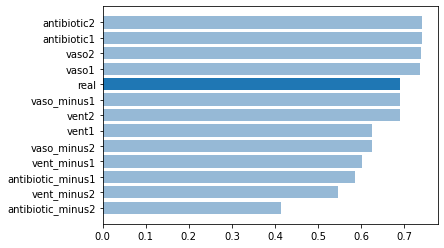

In [24]:
df.sort_values(by=['overall'], inplace=True)
import matplotlib.pyplot as plt
%matplotlib inline
mask = df['Simulator'] == 'real'
plt.barh(df['Simulator'], df['overall'], color='#96b9d6')
plt.barh(df['Simulator'][mask], df['overall'][mask])